####  Проблема: Поиск неизвестного сигнала.

По ссылке ниже вы можете найти результаты двух экспериментов из области физики частиц. (Конечно это симуляция, но давайте думать что это настоящие данные)
Данные представляют собой смесь выборок полученных их двух источников:
- Первый источник, назовем его фоном, дает равномерное распределение величины M в диапазоне от 0 до 10
- Второй источник, назовем его сигналом, нам не известен, но мы хотим проверить теорию по которой сигнальные события нормально распределены вокруг некоторого значения с некоторой шириной.
- Мы знаем, что наша экспериментальная установка не слишком точная, и измеренное значение M немного отличается от сгенерированного (с помощью сигнальной или фоновой модели). Измеренное значение распределено нормально вокруг истинного значения с шириной 0.1.

**Задача:**  используя данные обоих экспериментов, сделать вывод о том присутствует ли в них сигнал, и, если да, каковы его параметры
(сигнал может присутствовать а может и нет, параметры сигналов могут различаться)
[Ссылка на данные](https://u.pcloud.link/publink/show?code=VZR9StXZsCxkqS8Bq1VbczrxyrLay4sI81oX)


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import zfit
from zfit import z
from tqdm.notebook import tqdm
from scipy.stats import norm, uniform, chi2
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/Users/vladimir/.pyenv/versions/3.11.6/lib/python3.11/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
space = pd.read_csv('data/model1_test.csv', index_col='ind')
particle = pd.read_csv('data/model2_test.csv', index_col='ind')

In [3]:
space.describe(), particle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 1999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M       2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


(                 M
 count  1100.000000
 mean      4.758910
 std       2.919974
 min      -0.003838
 25%       2.053771
 50%       4.637162
 75%       7.445782
 max       9.991642,
 None)

In [4]:
particle.describe(), space.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1100 entries, 0 to 1099
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M       1100 non-null   float64
dtypes: float64(1)
memory usage: 17.2 KB


(                 M
 count  2000.000000
 mean      5.004077
 std       2.470644
 min      -1.060743
 25%       3.184742
 50%       5.006277
 75%       6.738719
 max      11.202380,
 None)

(array([[<Axes: title={'center': 'M'}>]], dtype=object),
 array([[<Axes: title={'center': 'M'}>]], dtype=object))

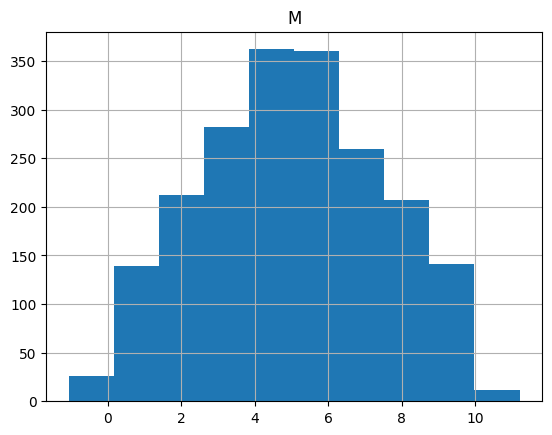

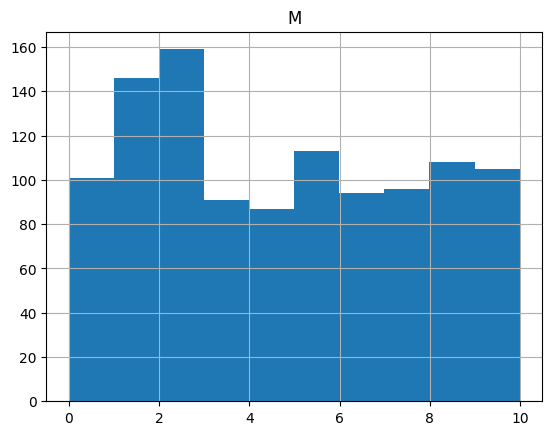

In [5]:
particle.hist(), space.hist()

In [6]:
float(space.min().iloc[0]), float(space.max().iloc[0])

(-0.0038378795802322, 9.991641924167906)

BEST F 0.07353464775622551


/var/folders/lh/8mw3k6xs0s353vyk9yzml2lm0000gn/T/ipykernel_77306/585230079.py:17: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(norm(mu,sigma).pdf(ds)*f+(1-f)/(b-a)))


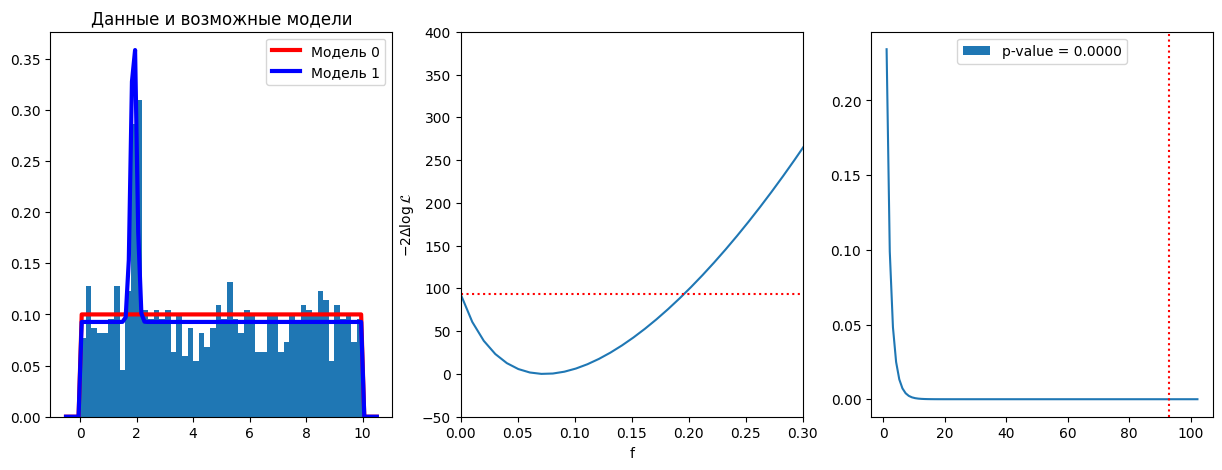

In [7]:
a = 0
b = 10
mu = 1.9
sigma = 0.1
f = 0.08

ds = pd.read_csv('data/model1_test.csv', index_col='ind').to_numpy()

# In case of Null hypothesis, we don't have any parameters and posteiror depends only on sample size
marg_likelihood_0 = (1/(b-a))

# For Altrnative hypothesis, lets first compute posteriror of f
def likelihood(f):
    return np.prod(norm(mu,sigma).pdf(ds)*f+(1-f)/(b-a))

def nll(f):
    return -np.sum(np.log(norm(mu,sigma).pdf(ds)*f+(1-f)/(b-a)))

best_f = minimize(nll, 0.5, bounds = [[0,1]]).x[0]

marg_likelihood_1 = quad(likelihood, 0,1)

B = marg_likelihood_1[0]/marg_likelihood_0
DLL = nll(0) - nll(best_f)

print("BEST F", best_f)

_, ax = plt.subplots(1,3,figsize = (15,5))
_x = np.linspace(a-0.5, b+0.5, 100)
ax[0].hist(ds, range = (a, b), bins = 50, density = True)
ax[0].plot(_x, uniform(a,b-a).pdf(_x), color = "red", linewidth = 3, label = "Модель 0")
ax[0].plot(_x, norm(mu,sigma).pdf(_x)*best_f+(1-best_f)*uniform(a,b-a).pdf(_x), color = "blue", linewidth = 3, label = f"Модель 1")
ax[0].legend()
ax[0].set_title(f"Данные и возможные модели")

_f = np.linspace(0,1,100)
ax[1].plot(_f,[2*(nll(_)-nll(best_f)) for _ in _f])
ax[1].set_xlabel("f")
ax[1].set_xlim([0, 0.3])
ax[1].set_ylim([-50, 400])
ax[1].axhline(2*DLL, color = "red", ls = ":")
ax[1].set_ylabel("$-2\Delta\log\mathcal{L}$")

_dll = np.linspace(0, 1.1*2*DLL, 100)
ax[2].plot(_dll, chi2(df=1).pdf(_dll))
ax[2].fill_between(_dll, chi2(df=1).pdf(_dll), where = _dll>2*DLL, label = f"p-value = {1-chi2(df=1).cdf(2*DLL):.4f}")
ax[2].axvline(2*DLL, color = "red", ls = ":")
ax[2].legend()

BEST F 0.44687822433544255


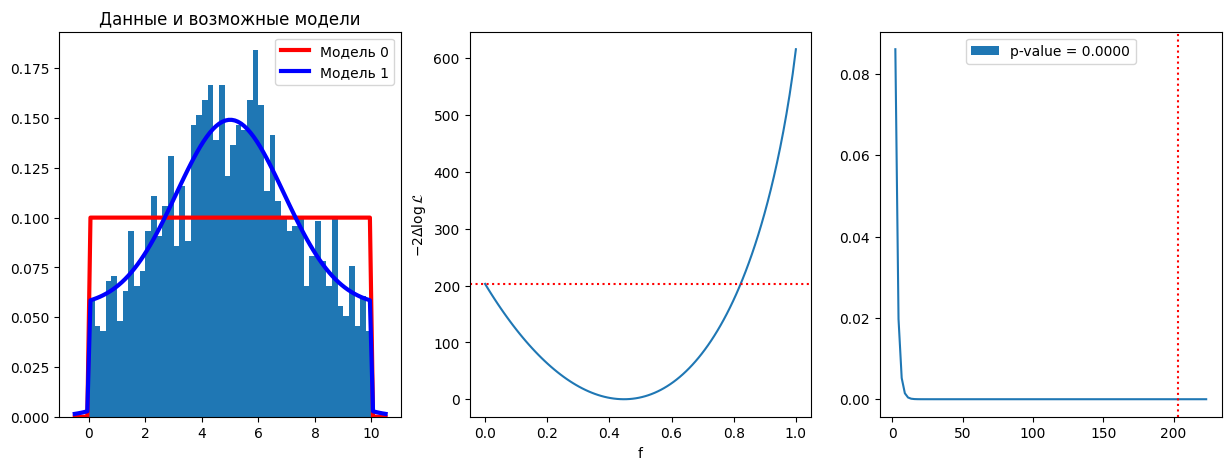

In [8]:
a = 0
b = 10
mu = 5
sigma = 1.9
f = 0.48

ds = pd.read_csv('data/model2_test.csv', index_col='ind').to_numpy()

# In case of Null hypothesis, we don't have any parameters and posteiror depends only on sample size
marg_likelihood_0 = (1/(b-a))

# For Altrnative hypothesis, lets first compute posteriror of f
def likelihood(f):
    return np.prod(norm(mu,sigma).pdf(ds)*f+(1-f)/(b-a))

def nll(f):
    return -np.sum(np.log(norm(mu,sigma).pdf(ds)*f+(1-f)/(b-a)))

best_f = minimize(nll, 0.5, bounds = [[0,1]]).x[0]

marg_likelihood_1 = quad(likelihood, 0,1)

B = marg_likelihood_1[0]/marg_likelihood_0
DLL = nll(0) - nll(best_f)

print("BEST F", best_f)

_, ax = plt.subplots(1,3,figsize = (15,5))
_x = np.linspace(a-0.5, b+0.5, 100)
ax[0].hist(ds, range = (a, b), bins = 50, density = True)
ax[0].plot(_x, uniform(a,b-a).pdf(_x), color = "red", linewidth = 3, label = "Модель 0")
ax[0].plot(_x, norm(mu,sigma).pdf(_x)*best_f+(1-best_f)*uniform(a,b-a).pdf(_x), color = "blue", linewidth = 3, label = f"Модель 1")
ax[0].legend()
ax[0].set_title(f"Данные и возможные модели")

_f = np.linspace(0,1,100)
ax[1].plot(_f,[2*(nll(_)-nll(best_f)) for _ in _f])
ax[1].set_xlabel("f")
ax[1].axhline(2*DLL, color = "red", ls = ":")
ax[1].set_ylabel("$-2\Delta\log\mathcal{L}$")

_dll = np.linspace(0, 1.1*2*DLL, 100)
ax[2].plot(_dll, chi2(df=1).pdf(_dll))
ax[2].fill_between(_dll, chi2(df=1).pdf(_dll), where = _dll>2*DLL, label = f"p-value = {1-chi2(df=1).cdf(2*DLL):.4f}")
ax[2].axvline(2*DLL, color = "red", ls = ":")
ax[2].legend()

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_0, f_1]] data=[<zfit.core.data.Data object at 0x2ca80e310>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 0.0001 │              2466.24 |  9173.926 │
╘═════════╧═════════════╧══════════════════╧════════╧══════════════════════════════════╛

Parameters
name       value  (rounded)    at limit
-------  ------------------  ----------
f_1               0.0871579       False
mu_1                1.99575       False
sigma_1            0.109604       False


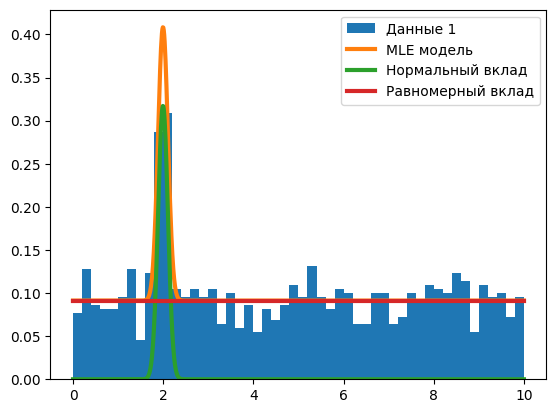

In [9]:
# Зададим область определения данных
obs = zfit.Space('x_1', limits=(0, 10))

# Зададим uniform модель
low = zfit.Parameter("low_1"   , 0, floating=False)
high = zfit.Parameter("high_1"   , 10, floating=False)
uniform = zfit.pdf.Uniform(obs=obs, low=low, high=high)

# Зададим нормальную модель
mu    = zfit.Parameter("mu_1"   , 0, 0, 4)
sigma = zfit.Parameter("sigma_1", 0.001, 0.001, 2)
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)

# Зададим комбинированую модель 0.073534
f =  zfit.Parameter("f_1", 0.5, 0, 1)
model = zfit.pdf.SumPDF([gauss, uniform], fracs=f)

# Сделаем выборку
data_1 = space.to_numpy()
data = zfit.Data.from_numpy(obs=obs, array=data_1)

# Зададим функцию потерь
nll = zfit.loss.UnbinnedNLL(model=model, data=data)

# Минимизируем функцию потерь
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
print(result)

# Изобразим результаты
x_plot = np.linspace(0, 10, 1000)
y_plot = zfit.run(model.pdf(x_plot, norm_range=obs))
y_plot_gs = zfit.run(gauss.pdf(x_plot, norm_range=obs))*f
y_plot_uni = zfit.run(uniform.pdf(x_plot, norm_range=obs))*(1-f)

plt.hist(data.numpy(), range = [0, 10], bins = 50, density = True, label = "Данные 1")
plt.plot(x_plot, y_plot, linewidth = 3,  label = "MLE модель")
plt.plot(x_plot, y_plot_gs, linewidth = 3,  label = "Нормальный вклад")
plt.plot(x_plot, y_plot_uni, linewidth = 3, label = "Равномерный вклад")
plt.legend()
plt.show()

In [10]:
n_mus = 20
n_sigmas = 20
n_f = 20
mus = np.linspace(1.5, 2.8, n_mus)
sigmas = np.linspace(0.08,0.3, n_sigmas)
f = np.linspace(0.05, 0.09, n_f)

nll_grid = np.zeros((n_sigmas,n_mus, n_f))
for i,_mu in tqdm(enumerate(mus)):
    for j,_sigma in enumerate(sigmas):
        for k, _f in enumerate(f):
            p = np.array([_f,_mu, _sigma])
            nll_grid[k, j,i] = float(nll(p))

nll_grid -= np.min(nll_grid)
likelihood_grid = np.exp(-nll_grid)
post_grid = likelihood_grid/likelihood_grid.sum()

0it [00:00, ?it/s]

In [11]:
# Найдем HDI для параметра mu с той же достоверностью
cl = 0.68
sorted_grid = np.sort(post_grid.flatten())[::-1]
integral = 0
i_max = 0
for i in range(len(mus)*len(sigmas)):
    integral += sorted_grid[i]
    if integral >= cl:
        i_max = i-1
        break

mask = np.array([np.isin(v, sorted_grid[:i_max]) for v in post_grid])

In [12]:
# В этом случае мы интегрируем по всем значениям
# параметра sigma
mu_post_grid = np.array([np.sum(x) for x in post_grid.T])
integral = 0
i_max = 0
mu_sorted_grid = np.sort(mu_post_grid)[::-1]
for i in range(len(mus)):
    integral += mu_sorted_grid[i]
    if integral >= cl:
        i_max = i - 1
        break
mu_mask = np.array([np.in1d(v, mu_sorted_grid[:i_max]) for v in mu_post_grid])

In [13]:
# Границы совместного доверительного интервала
fv, muv, sigmav = np.meshgrid(f, mus, sigmas)

mu_ll = np.min(muv[mask])
mu_ul = np.max(muv[mask])

sigma_ll = np.min(sigmav[mask])
sigma_ul = np.max(sigmav[mask])

f_ll = np.min(fv[mask])
f_ul = np.max(fv[mask])

# Границвы интервала для параметра mu
mu_true_ll = np.min(mus[mu_mask.flatten()])
mu_true_ul = np.max(mus[mu_mask.flatten()])

print(f"Доверительный интервал для mu [{mu_true_ll}, {mu_true_ul}]")
print(f"Доверительный интервал для sigma [{sigma_ll}, {sigma_ul}]")
print(f"Доверительный интервал для f [{f_ll}, {f_ul}]")

Доверительный интервал для mu [1.5, 2.731578947368421]
Доверительный интервал для sigma [0.16105263157894736, 0.16105263157894736]
Доверительный интервал для f [0.05421052631578947, 0.05842105263157895]


FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, f_2]] data=[<zfit.core.data.Data object at 0x2cc8fe750>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 0.00012 │              4443.58 |  9633.485 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name       value  (rounded)    at limit
-------  ------------------  ----------
mu_2                4.97714       False
sigma_2              1.9093       False


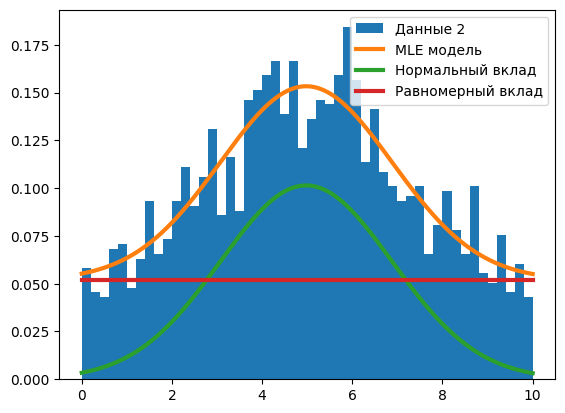

In [14]:
# Зададим область определения данных
obs = zfit.Space('x_2', limits=(0, 10))

# Зададим uniform модель
low = zfit.Parameter("low_2"   , 0, floating=False)
high = zfit.Parameter("high_2"   , 10, floating=False)
uniform = zfit.pdf.Uniform(obs=obs, low=low, high=high)

# Зададим нормальную модель
mu    = zfit.Parameter("mu_2"   , 3, 3, 7)
sigma = zfit.Parameter("sigma_2", 1, 1, 3)
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)

# Зададим комбинированую модель
f =  zfit.Parameter("f_2", 0.48109587, floating=False)
model = zfit.pdf.SumPDF([gauss, uniform], fracs=f)

# Сделаем выборку
data_2 = particle.to_numpy()
data = zfit.Data.from_numpy(obs=obs, array=data_2)

# Зададим функцию потерь
nll = zfit.loss.UnbinnedNLL(model=model, data=data)

# Минимизируем функцию потерь
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
print(result)

# Изобразим результаты
x_plot = np.linspace(0, 10, 1000)
y_plot = zfit.run(model.pdf(x_plot, norm_range=obs))
y_plot_gs = zfit.run(gauss.pdf(x_plot, norm_range=obs))*f
y_plot_uni = zfit.run(uniform.pdf(x_plot, norm_range=obs))*(1-f)

plt.hist(data.numpy(), range = [0, 10], bins = 50, density = True, label = "Данные 2")
plt.plot(x_plot, y_plot, linewidth = 3,  label = "MLE модель")
plt.plot(x_plot, y_plot_gs, linewidth = 3,  label = "Нормальный вклад")
plt.plot(x_plot, y_plot_uni, linewidth = 3, label = "Равномерный вклад")
plt.legend()
plt.show()

In [15]:
n_mus = 100
n_sigmas = 100
mus = np.linspace(4.5, 5.5, n_mus)
sigmas = np.linspace(1.1,2.5, n_sigmas)

nll_grid = np.zeros((n_sigmas,n_mus))
for i,_mu in tqdm(enumerate(mus)):
    for j,_sigma in enumerate(sigmas):
        p = np.array([_mu, _sigma])
        nll_grid[j,i] = float(nll(p))

nll_grid -= np.min(nll_grid)
likelihood_grid = np.exp(-nll_grid)
post_grid = likelihood_grid/likelihood_grid.sum()

0it [00:00, ?it/s]

In [16]:
# Найдем HDI для параметра mu с той же достоверностью
cl = 0.68
sorted_grid = np.sort(post_grid.flatten())[::-1]
integral = 0
i_max = 0
for i in range(len(mus)*len(sigmas)):
    integral += sorted_grid[i]
    if integral >= cl:
        i_max = i-1
        break
mask = np.array([np.in1d(v, sorted_grid[:i_max]) for v in post_grid])

In [17]:
# В этом случае мы интегрируем по всем значениям
# параметра sigma
mu_post_grid = np.array([np.sum(x) for x in post_grid.T])
integral = 0
i_max = 0
mu_sorted_grid = np.sort(mu_post_grid)[::-1]
for i in range(len(mus)):
    integral += mu_sorted_grid[i]
    if integral >= cl:
        i_max = i - 1
        break
mu_mask = np.array([np.in1d(v, mu_sorted_grid[:i_max]) for v in mu_post_grid])

In [18]:
# Границы совместного доверительного интервала
muv, sigmav = np.meshgrid(mus, sigmas)
mu_ll = np.min(muv[mask])
mu_ul = np.max(muv[mask])

sigma_ll = np.min(sigmav[mask])
sigma_ul = np.max(sigmav[mask])

# Границвы интервала для параметра mu
mu_true_ll = np.min(mus[mu_mask.flatten()])
mu_true_ul = np.max(mus[mu_mask.flatten()])

print(f"Доверительный интервал для mu [{mu_true_ll}, {mu_true_ul}]")
print(f"Доверительный интервал для sigma [{sigma_ll}, {sigma_ul}]")

Доверительный интервал для mu [4.883838383838384, 5.065656565656566]
Доверительный интервал для sigma [1.8, 2.0404040404040407]


/var/folders/lh/8mw3k6xs0s353vyk9yzml2lm0000gn/T/ipykernel_77306/4032877072.py:18: UserWarning: The following kwargs were not used by contour: 'color'
  ax[2].contourf(mus, sigmas, np.ones((n_mus, n_sigmas)) * mask, color='red')
/var/folders/lh/8mw3k6xs0s353vyk9yzml2lm0000gn/T/ipykernel_77306/4032877072.py:31: UserWarning: The following kwargs were not used by contour: 'color'
  ax[3].contourf(mus, sigmas, np.ones((n_mus, n_sigmas)) * mu_mask.T, color='red')


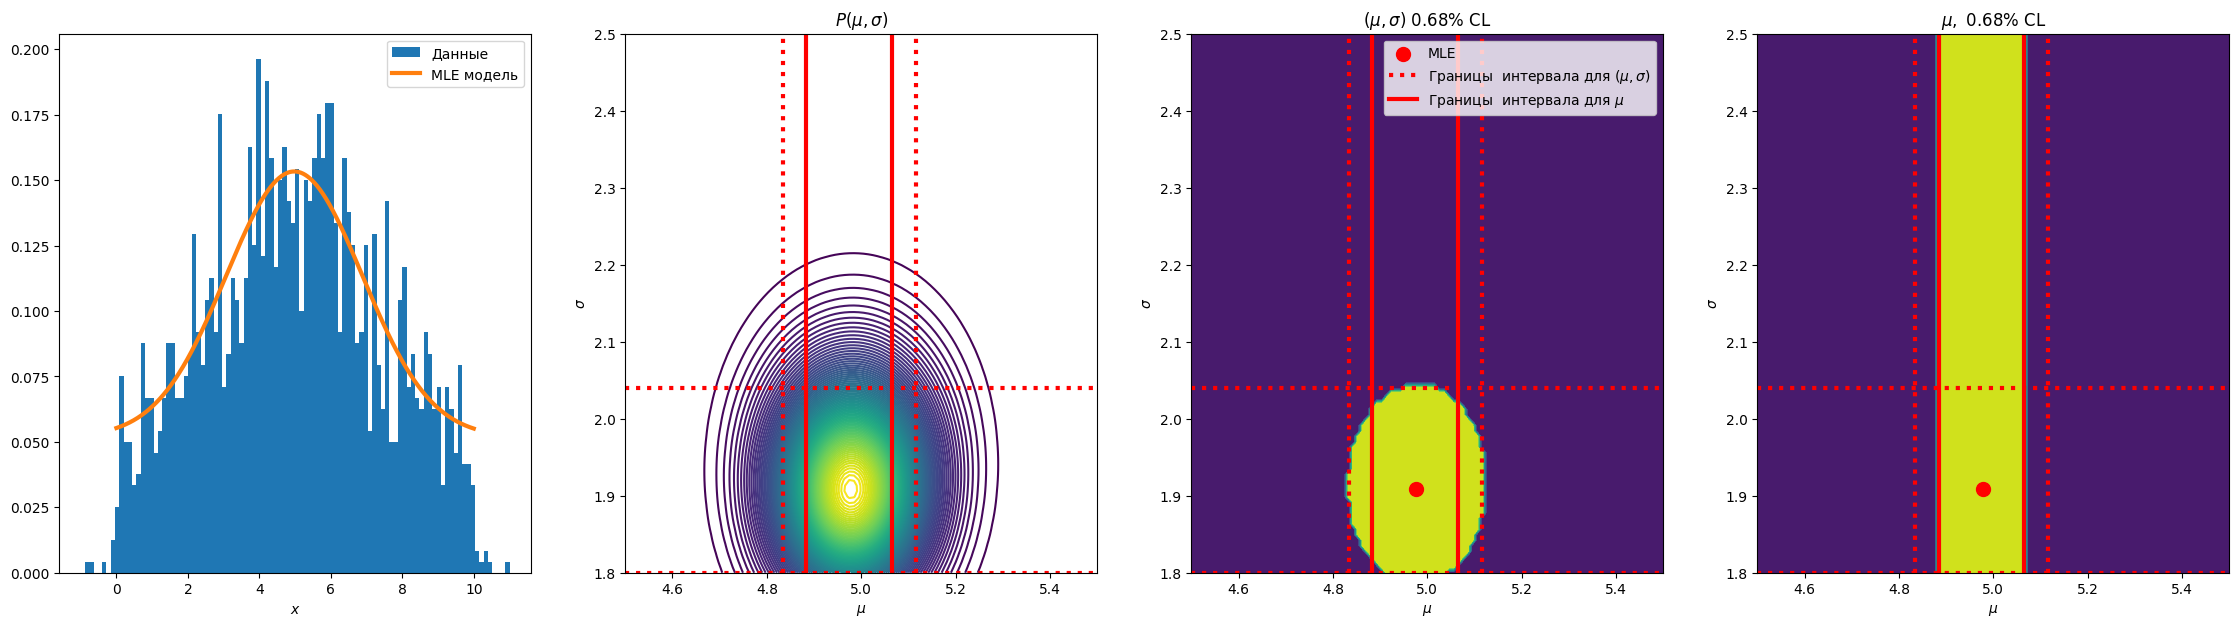

In [19]:
f, ax = plt.subplots(1, 4, figsize=(28, 7))
ax[0].hist(data_2, range=[-1, 11], bins=100, density=True, label="Данные")
ax[0].plot(x_plot, y_plot, linewidth=3, label="MLE модель")
ax[0].set_xlabel("$x$")
ax[0].legend()

ax[1].contour(mus, sigmas, post_grid, 100)
ax[1].axvline(mu_ll, color='red', ls=":", linewidth=3, label="Границы  интервала для $(\mu, \sigma)$")
ax[1].axvline(mu_ul, color='red', ls=":", linewidth=3)
ax[1].axvline(mu_true_ll, color='red', linewidth=3, label="Границы  интервала для $\mu$")
ax[1].axvline(mu_true_ul, color='red', linewidth=3)
ax[1].axhline(sigma_ll, color='red', ls=":", linewidth=3)
ax[1].axhline(sigma_ul, color='red', ls=":", linewidth=3)
ax[1].set_xlabel("$\mu$")
ax[1].set_ylabel("$\sigma$")
ax[1].set_title("$P(\mu, \sigma)$")

ax[2].contourf(mus, sigmas, np.ones((n_mus, n_sigmas)) * mask, color='red')
ax[2].scatter([result.params['mu_2']['value']], [result.params['sigma_2']['value']], color="red", s=100, label="MLE")
ax[2].axvline(mu_ll, color='red', ls=":", linewidth=3, label="Границы  интервала для $(\mu, \sigma)$")
ax[2].axvline(mu_ul, color='red', ls=":", linewidth=3)
ax[2].axvline(mu_true_ll, color='red', linewidth=3, label="Границы  интервала для $\mu$")
ax[2].axvline(mu_true_ul, color='red', linewidth=3)
ax[2].axhline(sigma_ll, color='red', ls=":", linewidth=3)
ax[2].axhline(sigma_ul, color='red', ls=":", linewidth=3)
ax[2].legend()
ax[2].set_xlabel("$\mu$")
ax[2].set_ylabel("$\sigma$")
ax[2].set_title(f'$(\mu,\sigma)$ {cl}% CL')

ax[3].contourf(mus, sigmas, np.ones((n_mus, n_sigmas)) * mu_mask.T, color='red')
ax[3].scatter([result.params['mu_2']['value']], [result.params['sigma_2']['value']], color="red", s=100, label="MLE")
ax[3].axvline(mu_ll, color='red', ls=":", linewidth=3, label="Границы  интервала для $(\mu, \sigma)$")
ax[3].axvline(mu_ul, color='red', ls=":", linewidth=3)
ax[3].axvline(mu_true_ll, color='red', linewidth=3, label="Границы  интервала для $\mu$")
ax[3].axvline(mu_true_ul, color='red', linewidth=3)
ax[3].axhline(sigma_ll, color='red', ls=":", linewidth=3)
ax[3].axhline(sigma_ul, color='red', ls=":", linewidth=3)
ax[3].set_xlabel("$\mu$")
ax[3].set_ylabel("$\sigma$")
ax[3].set_title(f'$\mu,$ {cl}% CL')

plt.show()